# Google Colab preliminary
Configuration of the virtual machine. Clone then install the package [scikit-maad](https://scikit-maad.github.io/) in order to download also the data to be able to execute the example.


# Remove background noise with signal processing tools

Environmental audio recordings usually have stationary noise that needs to be removed to
enhance the signal to noise ratio of biological sounds.
This example shows different ways to remove stationary background noise using spectral
subtraction techniques. These techniques are applied over the spectrogram and return a 2D matrix.
We use the sharpness metric to have a quantitative estimation of how well is the noise
reduction. For a more comprehensive analysis, other metrics should be use in complement.


In [7]:
# sphinx_gallery_thumbnail_path = './_images/sphx_glr_plot_remove_background_002.png'

from maad.util import plot2d, power2dB, plot_spectrogram
from maad.sound import (load, spectrogram,
                       remove_background, median_equalizer,
                       remove_background_morpho,
                       remove_background_along_axis, sharpness)
import numpy as np

from timeit import default_timer as timer

import matplotlib.pyplot as plt

## Load and plot the spectrogram of the original audio file
First, we load the audio file and take its spectrogram.
The linear spectrogram is then transformed into dB. The dB range is  96dB
which is the maximum dB range value for a 16bits audio recording. We add
96dB in order to get have only positive values in the spectrogram.



Original sharpness : 4.628


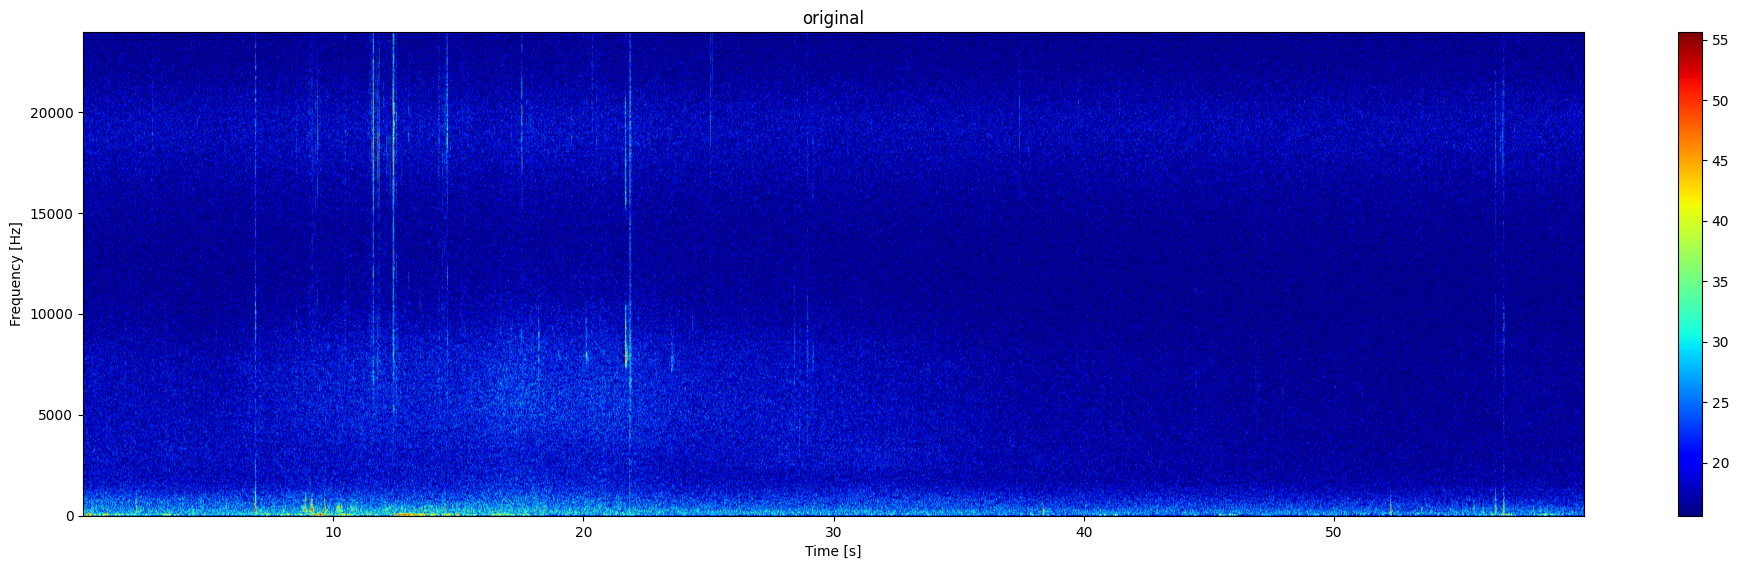

In [23]:
DATA_PATH = "./Ecoacoustics_Longitudinal_Altitude_Project/Point_1"  # dossier racine à traiter
filename = DATA_PATH + "/20250930_170000.wav"


s, fs = load(filename)  # load 1 minute of sound
Sxx, tn, fn, ext = spectrogram(s, fs, fcrop=[0,20000], tcrop=[0,60])
Sxx_dB = power2dB(Sxx, db_range=96)+96
plot2d(Sxx_dB, extent=ext, title='original',
       vmin=np.median(Sxx_dB), vmax=np.median(Sxx_dB)+40, cmap='jet')

# plot_spectrogram(Sxx, ext, title='Original Spectrogram', cmap='jet', log_scale=True)

print ("Original sharpness : %2.3f" % sharpness(Sxx_dB))

In [41]:
import librosa 

Sxx, tn, fn, ext = spectrogram(s, fs, fcrop=[0,20000], tcrop=[0,60], mode = 'amplitude')
Sxx_dB = power2dB(Sxx, db_range=96)+96
# plot2d(Sxx_dB, extent=ext, title='original',
#        vmin=np.median(Sxx_dB), vmax=np.median(Sxx_dB)+40, cmap='jet')


sound_hat = librosa.griffinlim(Sxx, n_iter=64)

spec_hat, tn_hat, fn_hat, ext_hat = spectrogram(sound_hat, fs, fcrop=[0,20000], tcrop=[0,60])
spec_hat_dB = power2dB(spec_hat, db_range=96)+96

# figure(figsize=(10, 4))
# plot2d(spec_hat_dB, extent=ext_hat, title='Reconstructed Spectrogram',
#        vmin=np.median(spec_hat_dB), vmax=np.median(spec_hat_dB)+40, cmap='jet')


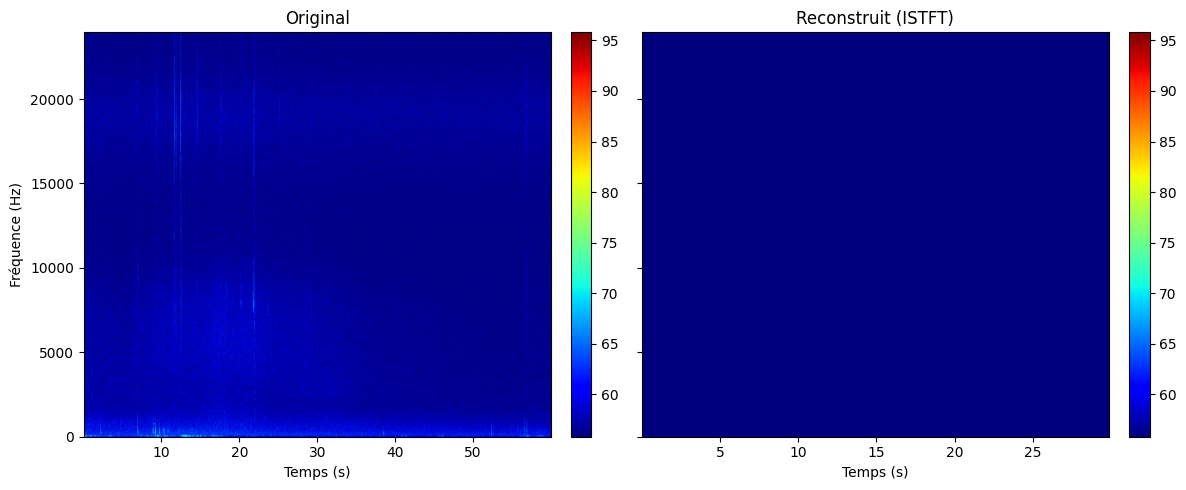

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Tes deux spectrogrammes en dB :
# Sxx_dB       → spectrogramme original
# spec_hat_dB  → spectrogramme reconstruit
# ext, ext_hat → extent (axes [time, freq]) si tu veux les mêmes échelles

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Figure 1 : original ---
im1 = axes[0].imshow(
    Sxx_dB,
    aspect='auto',
    origin='lower',
    extent=ext,
    cmap='jet',
    vmin=np.median(Sxx_dB),
    vmax=np.median(Sxx_dB) + 40
)
axes[0].set_title("Original")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquence (Hz)")
plt.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# --- Figure 2 : reconstruit ---
im2 = axes[1].imshow(
    spec_hat_dB,
    aspect='auto',
    origin='lower',
    extent=ext_hat,
    cmap='jet',
    vmin=np.median(Sxx_dB),
    vmax=np.median(Sxx_dB) + 40
)
axes[1].set_title("Reconstruit (ISTFT)")
axes[1].set_xlabel("Temps (s)")
plt.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [43]:
sound_hat.max()

np.float64(0.0002969429851143032)

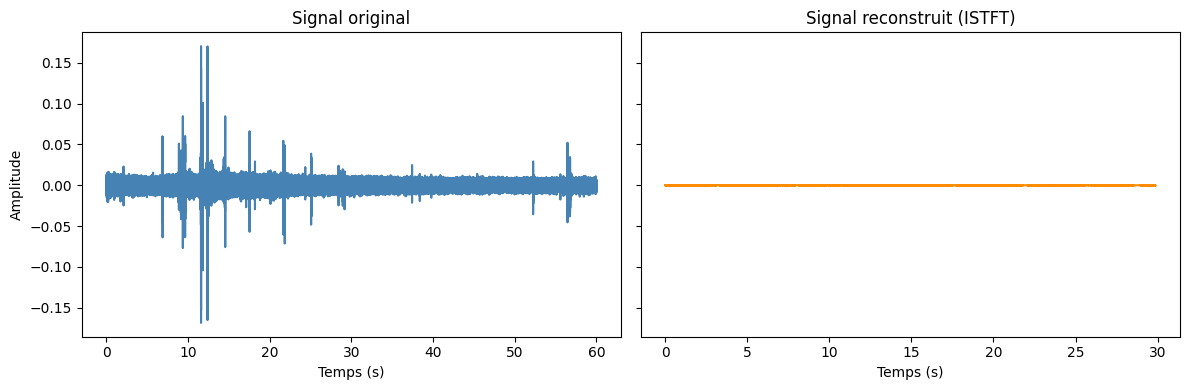

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# s         = signal original (1D array)
# sound_hat = signal reconstruit via librosa.istft
# fs        = fréquence d’échantillonnage

# Crée les axes de temps
t = np.arange(len(s)) / fs
t_hat = np.arange(len(sound_hat)) / fs

# Affiche les deux signaux côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Signal original ---
axes[0].plot(t, s, color='steelblue')
axes[0].set_title("Signal original")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Amplitude")

# --- Signal reconstruit ---
axes[1].plot(t_hat, sound_hat, color='darkorange')
axes[1].set_title("Signal reconstruit (ISTFT)")
axes[1].set_xlabel("Temps (s)")

plt.tight_layout()
plt.show()


## Test different methods to remove stationary background noise
Test the function "remove_background"



---- test remove_background -----
duration 0.132 s
sharpness : 3.225


(<Axes: title={'center': 'remove_background'}, xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1979.3x579.062 with 2 Axes>)

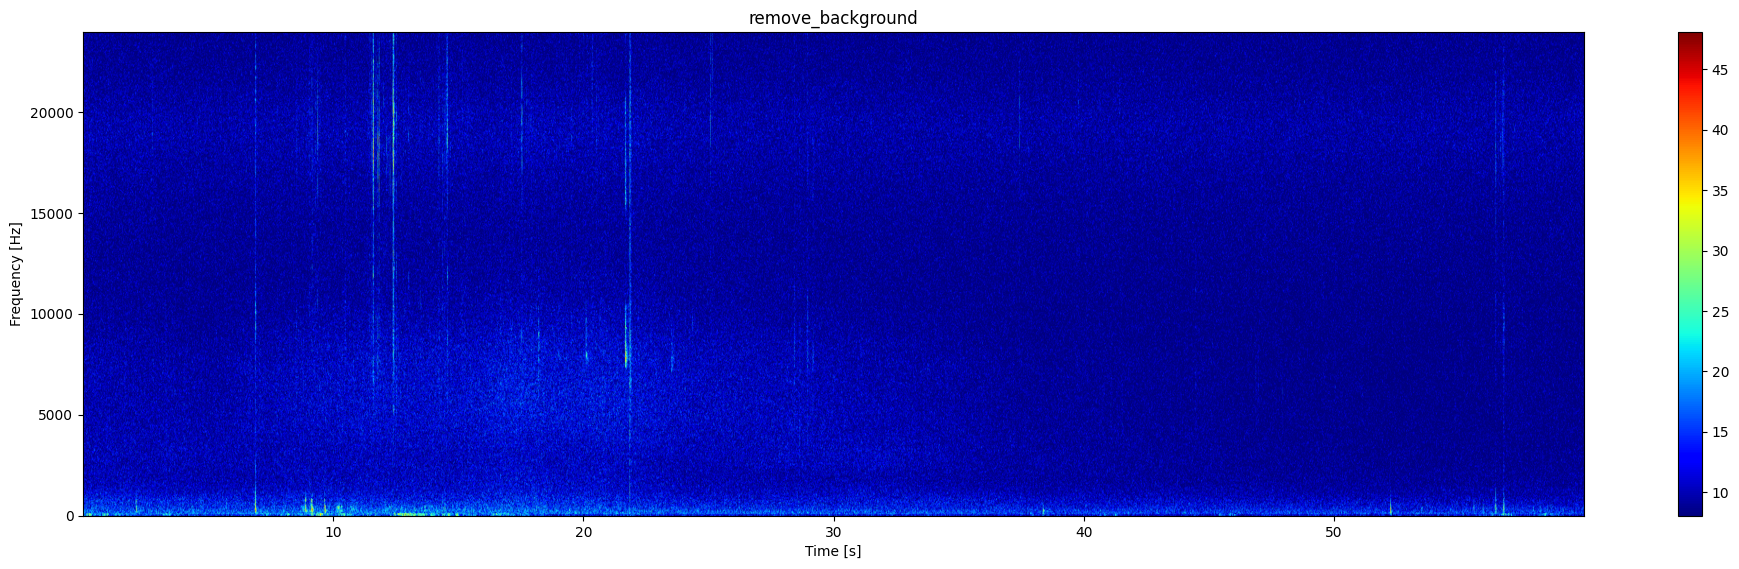

In [25]:
start = timer()
X1, noise_profile1, _ = remove_background(Sxx_dB)
elapsed_time = timer() - start
print("---- test remove_background -----")
print("duration %2.3f s" % elapsed_time)
print ("sharpness : %2.3f" % sharpness(X1))

plot2d(X1, extent=ext, title='remove_background',
       vmin=np.median(X1), vmax=np.median(X1)+40, cmap='jet')

Test the function "median_equalizer"



---- test median_equalizer -----
duration 0.460 s
sharpness : 1.343


(<Axes: title={'center': 'median_equalizer'}, xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1979.3x579.062 with 2 Axes>)

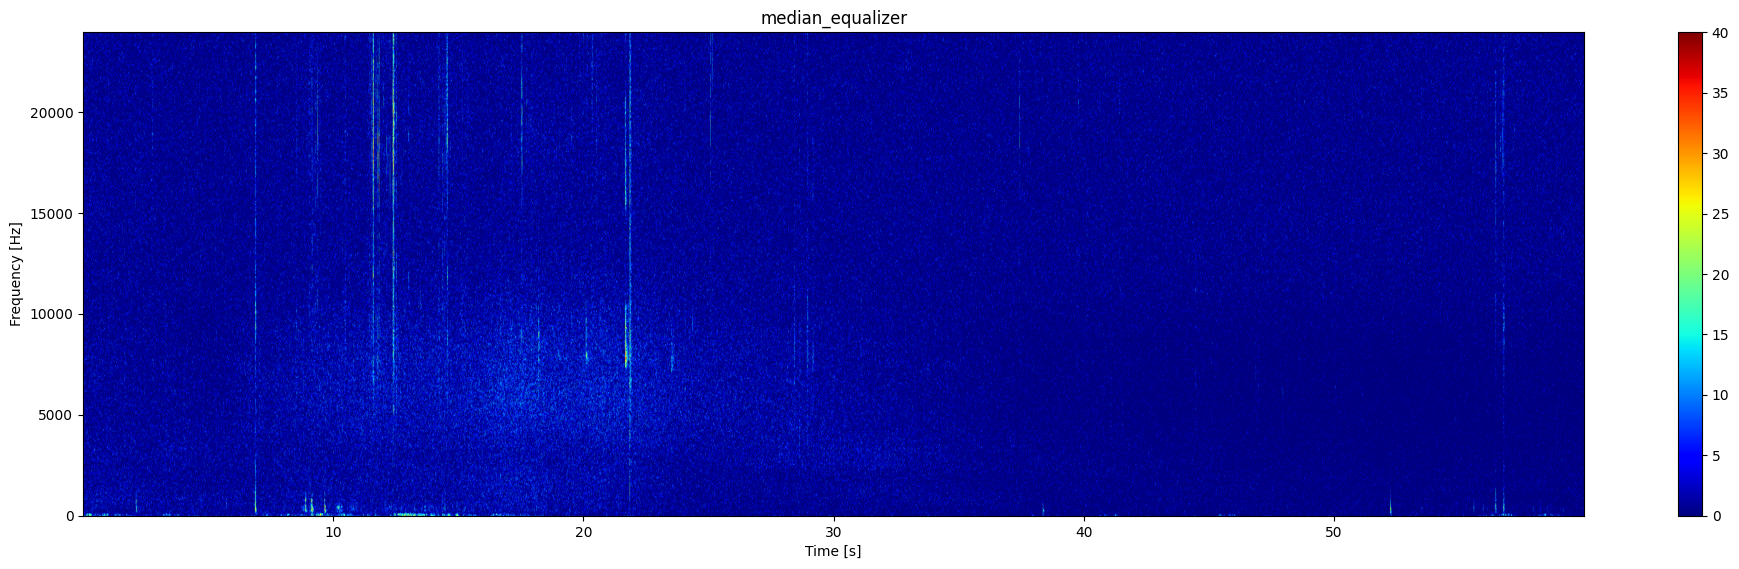

In [26]:
start = timer()
X2 = median_equalizer(Sxx)
X2 = power2dB(X2)
elapsed_time = timer() - start
print("---- test median_equalizer -----")
print("duration %2.3f s" % elapsed_time)
print ("sharpness : %2.3f" %sharpness(X2))

plot2d(X2,extent=ext, title='median_equalizer',
       vmin=np.median(X2), vmax=np.median(X2)+40, cmap='jet')

Test the function "remove_background_morpho"



---- test remove_background_morpho -----
duration 3.850 s
sharpness : 1.528


(<Axes: title={'center': 'remove_background_morpho'}, xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1979.3x579.062 with 2 Axes>)

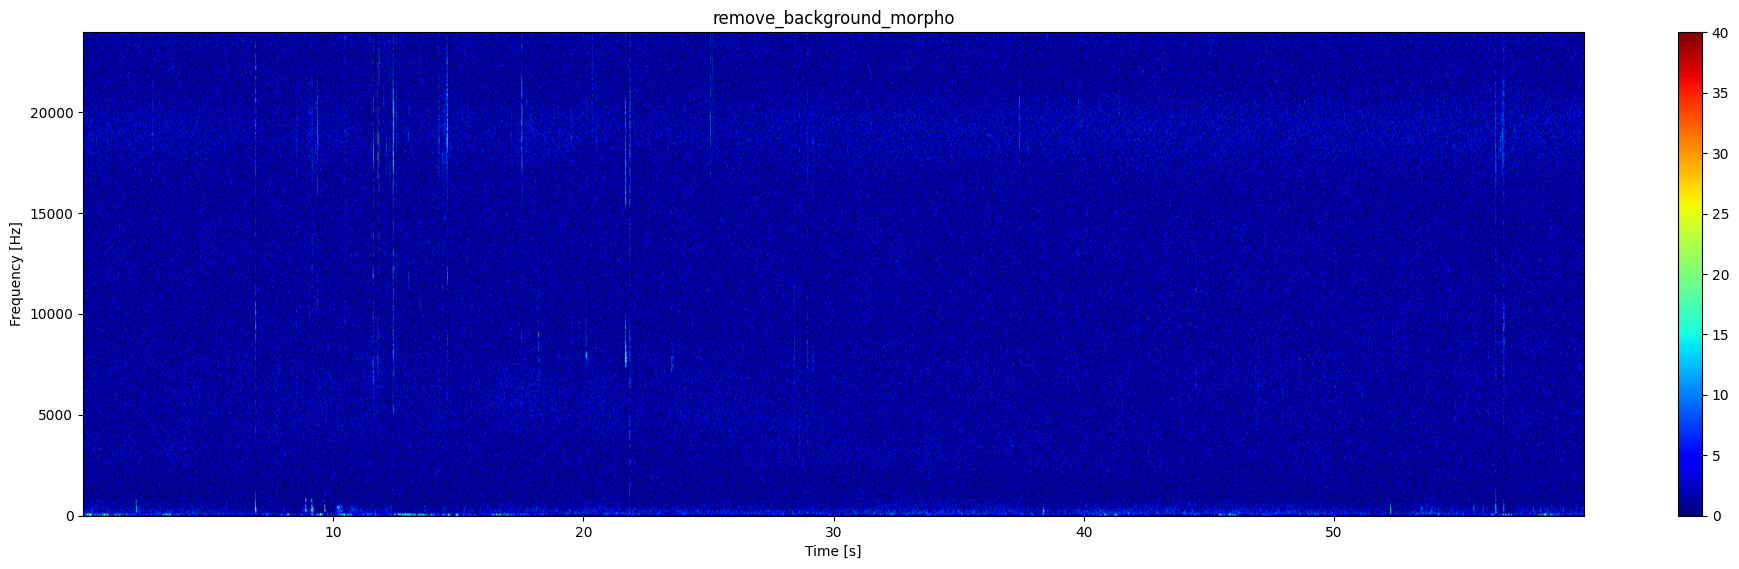

In [27]:
start = timer()
X3, noise_profile3,_ = remove_background_morpho(Sxx_dB, q=0.95)
elapsed_time = timer() - start
print("---- test remove_background_morpho -----")
print("duration %2.3f s" % elapsed_time)
print ("sharpness : %2.3f" %sharpness(X3))

plot2d(X3, extent=ext, title='remove_background_morpho',
       vmin=np.median(X3), vmax=np.median(X3)+40, cmap='jet')

Test the function "remove_background_along_axis"



---- test remove_background_along_axis -----
duration 0.210 s
sharpness : 1.914


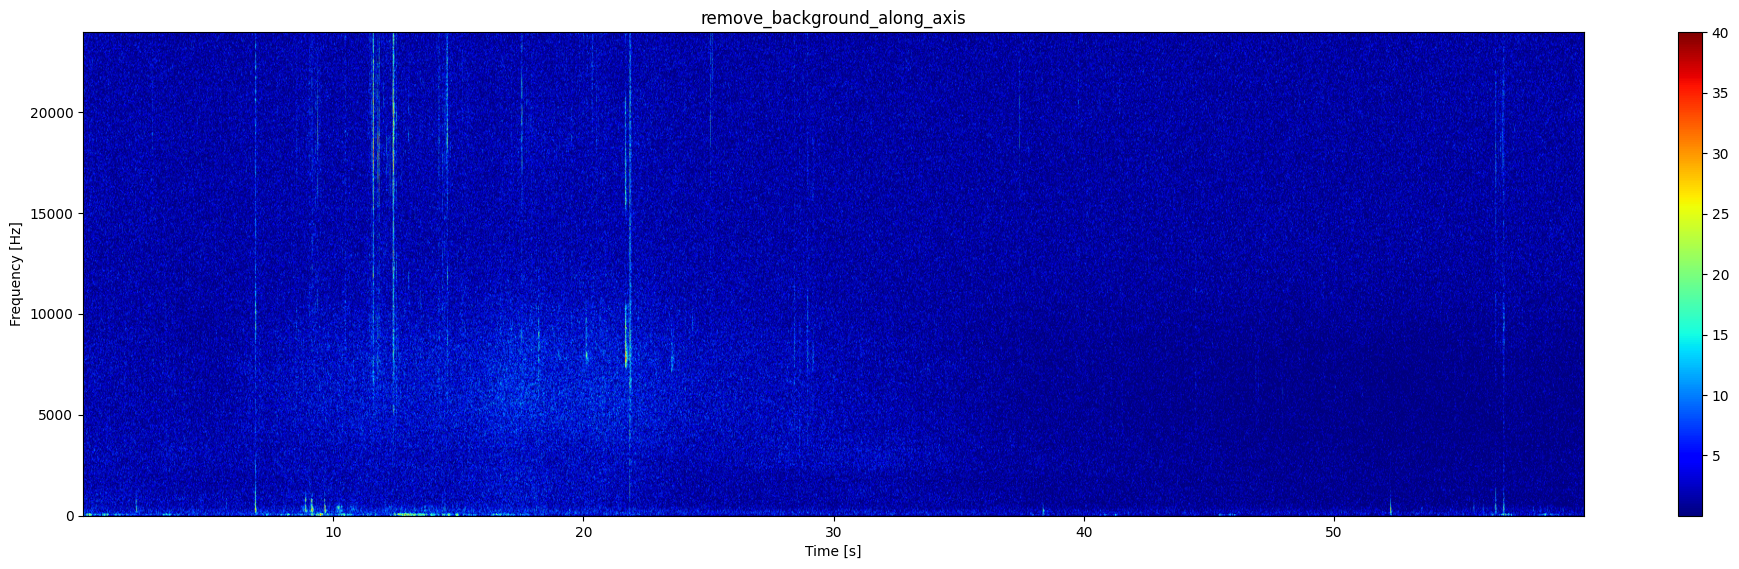

In [28]:
start = timer()
X4, noise_profile4 = remove_background_along_axis(Sxx_dB,mode='median', axis=1)
#X4 = power2dB(X4)
elapsed_time = timer() - start
print("---- test remove_background_along_axis -----")
print("duration %2.3f s" % elapsed_time)
print ("sharpness : %2.3f" %sharpness(X4))

plot2d(X4,  extent=ext, title='remove_background_along_axis',
       vmin=np.median(X4), vmax=np.median(X4)+40, cmap='jet')

plt.tight_layout()